# Задача классификации. kNN





Перед тем, как строить модели, хорошо бы понять, а как мы будем измерять качество их работы?

Мы с вами будем работать с задачей бинарной классификации, то есть возможных вариантов целевой переменной может быть всего 2. Для наглядности предположим, что предсказываем беременность.

В этом случае у нашего алгоритма может быть 4 варианта развития событий - предсказать беременность, когда она действительно есть, предсказать её отсутствие, когда её действительно нет, или совершить один из двух типов ошибок:

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

* Ошибка первого рода: мы предсказали человеку, что он беременен, а по факту нет.
* Ошибка второго рода: мы предсказали, что человек не беременен, а по факту - да.


![](https://miro.medium.com/max/3200/1*fSOPZZt8Bbm-lzNQhfqRLw.jpeg)



В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик.


### 1) Доля верно классифицированных объектов (Accuracy):

Берем всё, что предсказали правильно, делим на число всех наблюдений

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным.

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту.

### 2) Точность (Precision):

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку.

### 3) Полнота (Recall):

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Давайте составим для алгоритма из первого пункта матрицу ошибок и подсчитаем эти две метркии. Под классом $1$ будем понимать больных. Именно их мы хотели бы найти.  


|          | $y=1$ | $y=0$ |
|----------|-------|-------|
|$a(x) = 1$|  0    |  0    |
|$a(x) = 0$|  50   |  950  |


Точность будет равна нулю. Полнота тоже. Мы видим насколько алгоритм никчёмен.

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, нам бы хотелось получить максимальную полноту. Не страшно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру:

### 4) F-measure:

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому.

Все эти метрики, конечно же, уже есть в пакете sklearn.

```python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Задача классификации. Метод ближайших соседей (kNN)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline
#plt.rcParams["figure.figsize"] = [8, 8]

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

## KNN в задаче классификации

## kNN



[Предсказание ортопедических проблем](https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#_=_) по измерениям костей таза и нижнего позвоночника. Быстро пройдемся по основным этапам работы с данными.

Загрузка - Статистики и Визуализация - Предобработка - Моделирование

In [ ]:
!wget -O column_2C_weka.csv 'https://drive.usercontent.google.com/download?id=1QC_0vUeyKvNOUPpy3W6Ag9l6knIG4nVO&export=download&authuser=0&confirm=t&uuid=1de6b015-e2f5-4393-ab84-08874c1454dc&at=AENtkXbxNEake29ft10nZPJt-Yp4:1731814873853'

--2024-11-23 14:29:54--  https://drive.usercontent.google.com/download?id=1QC_0vUeyKvNOUPpy3W6Ag9l6knIG4nVO&export=download&authuser=0&confirm=t&uuid=1de6b015-e2f5-4393-ab84-08874c1454dc&at=AENtkXbxNEake29ft10nZPJt-Yp4:1731814873853
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.99.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24961 (24K) [application/octet-stream]
Saving to: ‘column_2C_weka.csv’

column_2C_weka.csv  100%[===================>]  24.38K  --.-KB/s    in 0s      

2024-11-23 14:29:57 (55.1 MB/s) - ‘column_2C_weka.csv’ saved [24961/24961]



In [ ]:
data = pd.read_csv('column_2C_weka.csv')

In [ ]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [ ]:
data.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [ ]:
data.isnull().sum()

,0
pelvic_incidence,0
pelvic_tilt numeric,0
lumbar_lordosis_angle,0
sacral_slope,0
pelvic_radius,0
degree_spondylolisthesis,0
class,0


## Распределение целевой переменной

In [ ]:
data['class'].value_counts()

,count
class,
Abnormal,210
Normal,100


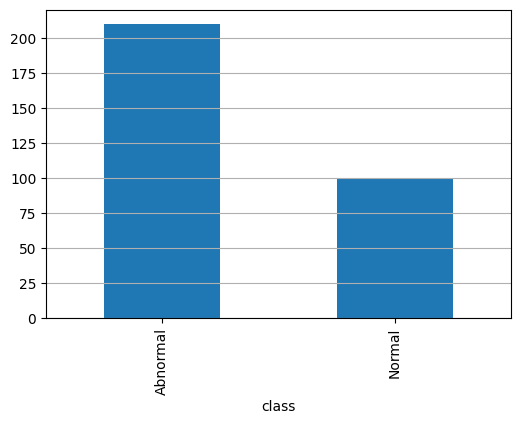

In [ ]:
data['class'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [ ]:
data['class'].value_counts(normalize=True)

,proportion
class,
Abnormal,0.677419
Normal,0.322581


Здесь же можно прикинуть наш **baseline** качества, с которым можно будет сравнивать результаты работы модели. Если у нас 68% одного класса и 32% другого, то даже если наша модель будет предсказывать сплошные `Abnormal`, то `accuracy` будет равна, в среднем, 68%.

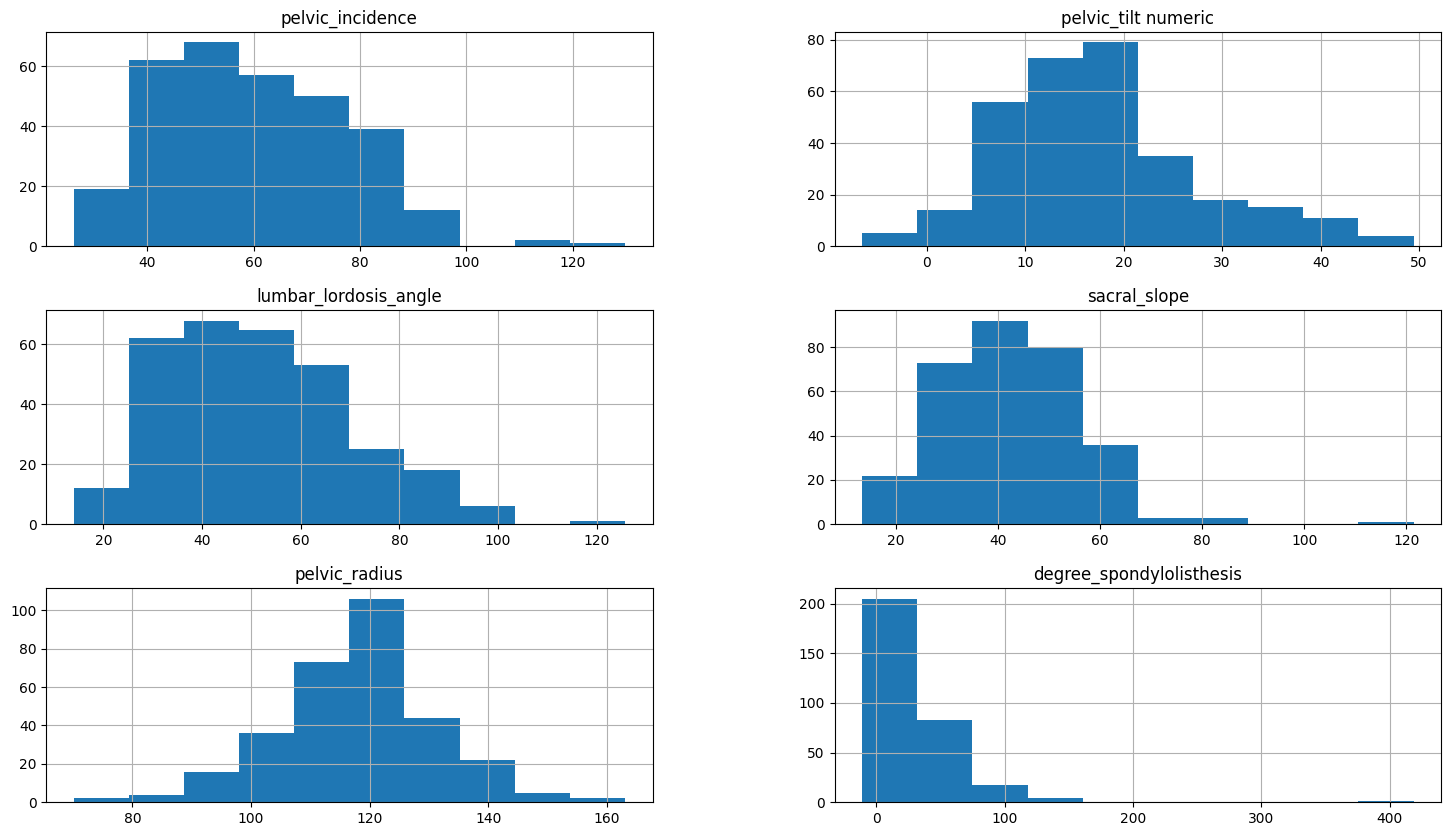

In [ ]:
data.hist(figsize=(18, 10));

## Перекодируем целевую

In [ ]:
data['class'] = data['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

In [ ]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


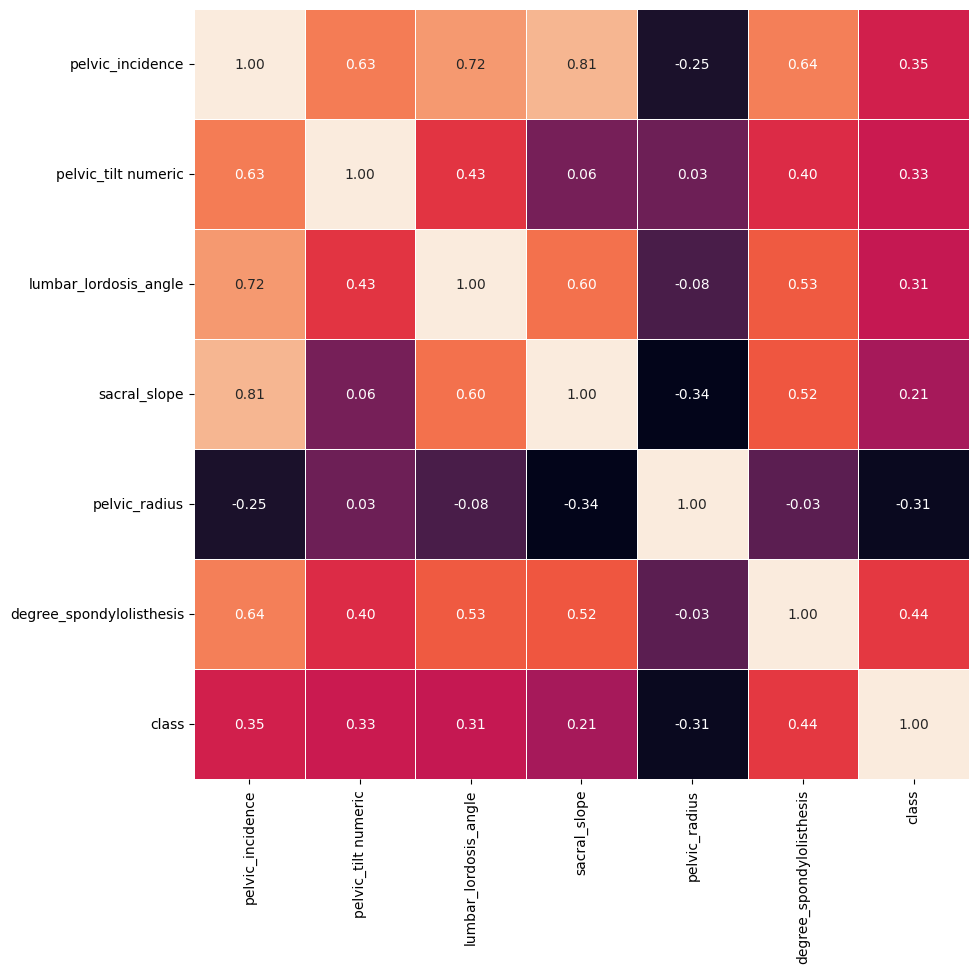

In [ ]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

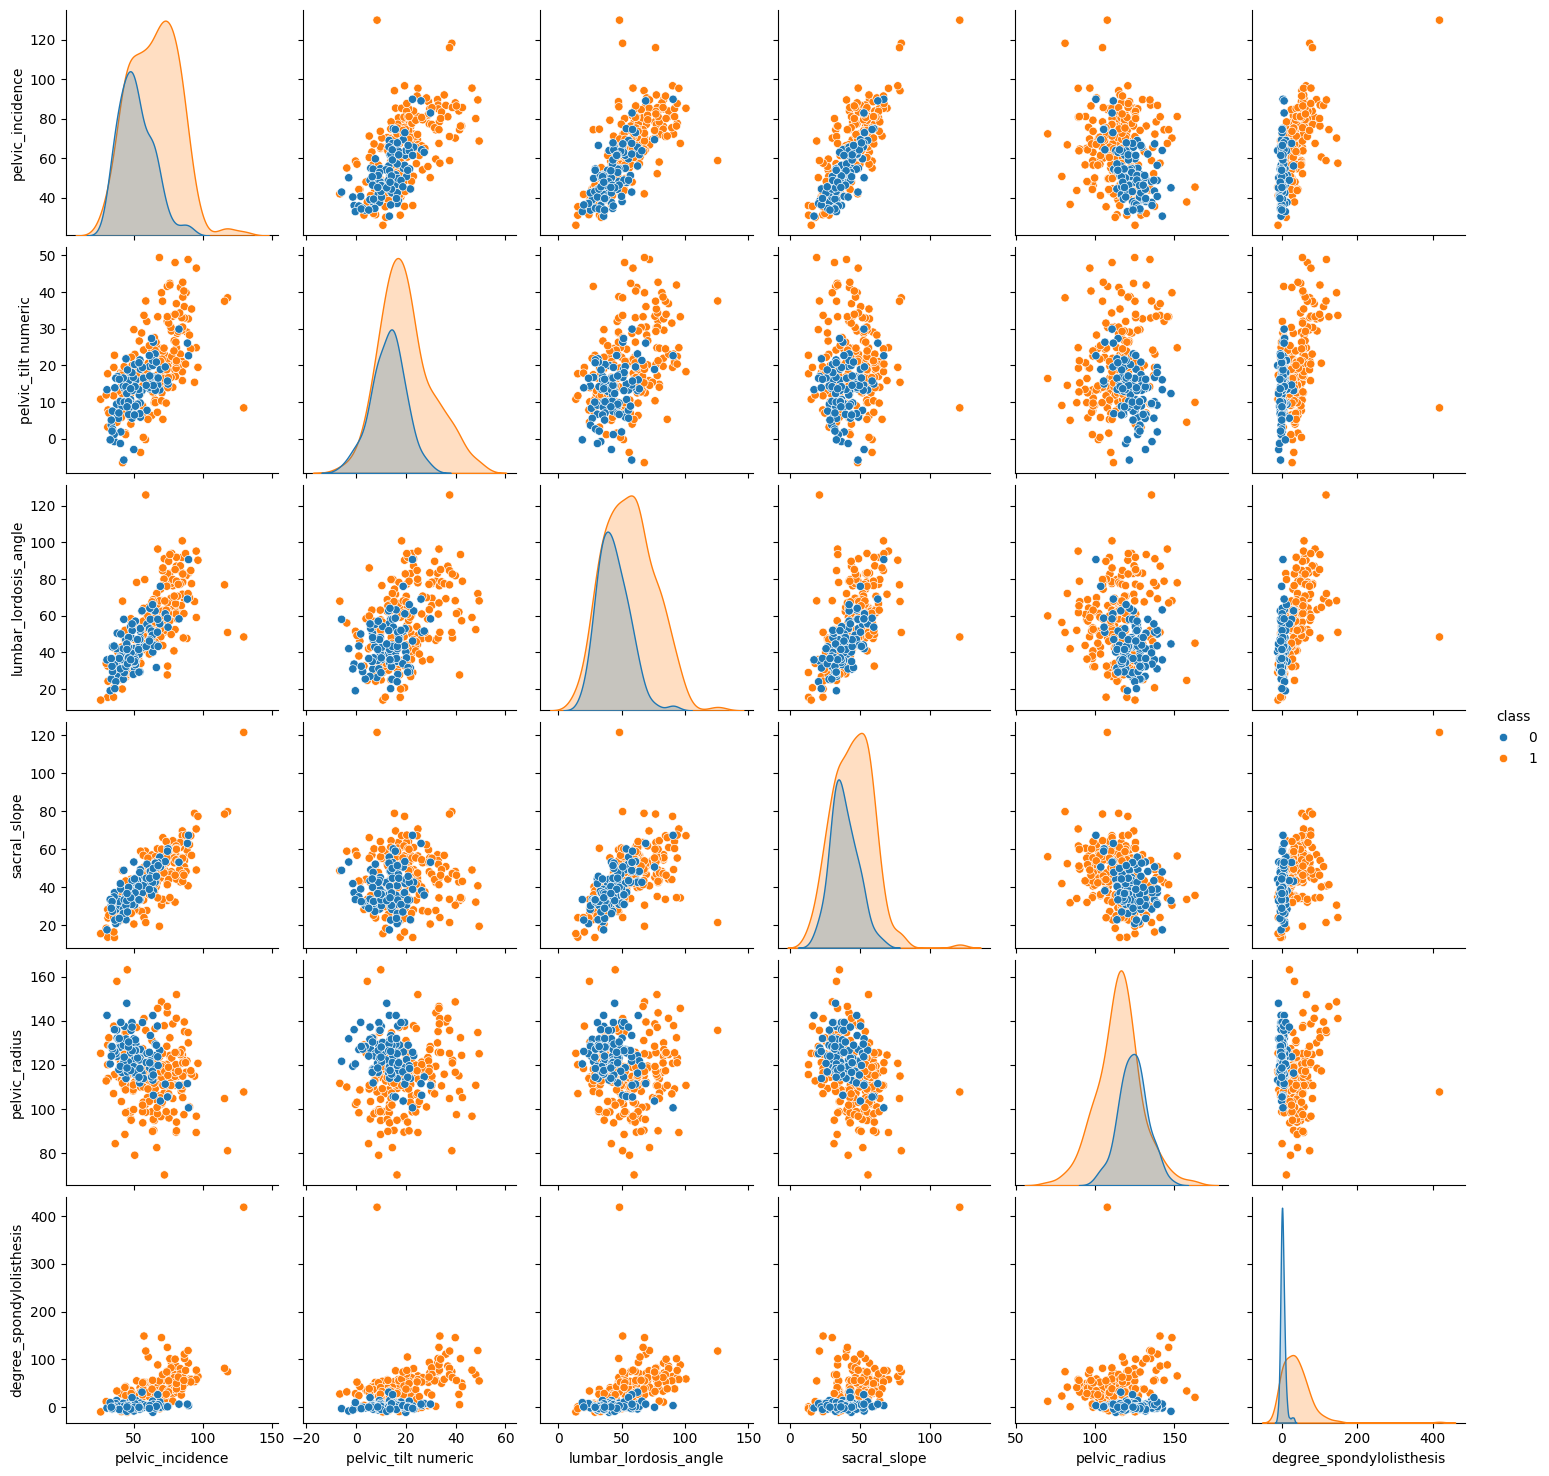

In [ ]:
sns.pairplot(data, hue='class');

## Train-test split

Параметр `stratify` позволяет вам создавать такие разбиения, в которых распределения указанной переменной будут сохраняться. Очень полезно при дисбалансе классов, т.е. когда каких-то классов гораздо больше, чем других.

Попробуйте ответить, почему?

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['class'], axis=1), data['class'], test_size=0.20, random_state=42, stratify=data['class']
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 6), (62, 6), (248,), (62,))

In [ ]:
y_train.value_counts(normalize=True)

,proportion
class,
1,0.677419
0,0.322581


In [ ]:
y_test.value_counts(normalize=True)

,proportion
class,
1,0.677419
0,0.322581


## Scaling
### Важно!
Учим на трейне - применяем на тесте. Практически все методы препроцессинга так или иначе используют информацию из выборки, например, при стандартизации считается среднее и дисперсия, значит, мы не хотим, чтобы информация из отложенной выборки просачивалась в тренировочную (data leak).

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подбор параметров разными способами

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

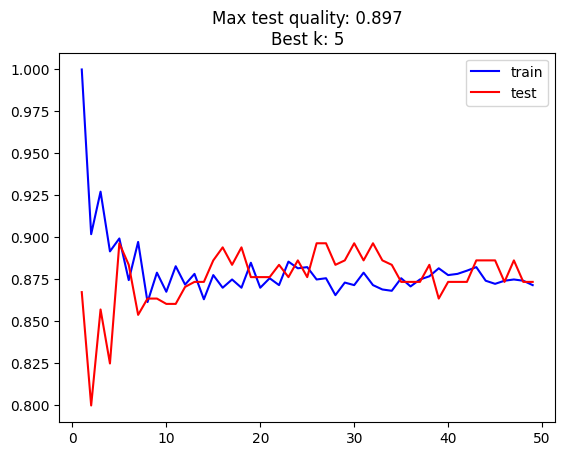

In [ ]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test))

plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

## Bonus: GridSearchCV

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
)


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Fitting 5 folds for each of 147 candidates, totalling 735 fits
Best CV score: 0.885, best CV k: 33
Resulting test score: 0.886
CPU times: user 7.87 s, sys: 54.2 ms, total: 7.92 s
Wall time: 7.98 s


In [ ]:
grid_search.best_estimator_.p

2

In [ ]:
grid_search.best_estimator_.n_neighbors

33